# 11.1 优化和深度学习
- **目录**
  - 11.1.1 优化的目标
  - 11.1.2 深度学习中的优化挑战
    - 11.1.2.1 局部最小值
    - 11.1.2.2 鞍点
    - 11.1.2.3 梯度消失

- 在本节中，我们将讨论优化与深度学习之间的关系以及在深度学习中使用优化的挑战。
对于深度学习问题，通常会先定义**损失函数**。一旦有了损失函数，就可以**使用优化算法来尝试最小化损失**。
- 在优化中，损失函数通常被称为优化问题的**目标函数**。
- 按照传统和惯则，大多数优化算法都关注的是**最小化**。
- 如果需要最大化目标，那么有一个简单的解决方案：在目标函数前**加负号**即可。

- **最优化理论方面的参考教材**
  
<img src= '../img/11_1_1.png' width=400px/>

## 11.1.1 优化的目标

- 尽管优化提供了一种最大限度地减少深度学习损失函数的方法，但实质上，**优化和深度学习的目标是根本不同的**。
  - 前者主要关注的是**最小化目标**，后者则关注在给定**有限数据量**的情况下**寻找合适的模型**。
- 在 4.4节中，我们详细讨论了这两个目标之间的区别。
  - 例如，训练误差和泛化误差通常不同：由于优化算法的目标函数通常是基于训练数据集的损失函数，因此**优化的目标是减少训练误差**。
  - 但是深度学习（或更广义地说，统计推断）的目标是**减少泛化误差**。
- 为了实现后者，**除了使用优化算法来减少训练误差之外，我们还需要注意过拟合。**

In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

- 为了说明上述不同的目标，需考虑经验风险和风险。
- 如4.9.3.1节所述，**经验风险是训练数据集的平均损失，而风险则是整个数据群的预期损失**。
- 下面定义了两个函数：风险函数`f`和经验风险函数`g`。
  - 假设我们只有有限量的训练数据。因此，这里的`g`不如`f`平滑。


---------------
- **说明：风险与经验风险**
  - **风险（Risk）**：风险是模型在整个数据分布上的预期损失。它代表了模型在未知数据（比如来自同一分布但不在训练集中的数据）上的表现。理想情况下，我们希望直接最小化风险，即找到一个模型，使得它在所有可能的数据上的平均误差最小。然而，因为我们无法获得整个数据分布，所以无法直接计算和最小化风险。
  - **经验风险（Empirical Risk）**：经验风险是模型在训练数据集上的平均损失。不同于风险，**经验风险可以直接通过训练数据计算得到**。在训练过程中，我们的目标通常是最小化经验风险。然而，仅最小化经验风险并不能保证模型在未知数据上的表现，也就是说，模型可能会**过拟合**训练数据。
  - 风险和经验风险的主要区别在于他们针对的数据集不同：
    - 风险是对整个数据分布的度量，而经验风险只考虑训练数据。
    - 二者的联系在于：通过最小化经验风险，我们希望能够间接地最小化风险，从而提高模型的泛化能力。
  - **举例**：
    - 例如，假设我们有一个用于预测房价的模型，训练数据是1000个房屋的特征和价格。经验风险就是这个模型在这1000个训练样本上的平均预测误差。
    - 然而，风险是这个模型在所有可能的房屋（包括训练集以外的房屋）上的预测误差的平均值。
    - 通常情况下是无法得到所有房屋的数据，所以无法直接计算风险。
    - 因此，在训练模型时，模型试图最小化经验风险，希望最小化风险，提高模型在新房屋上的预测性能。
-----------

In [2]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

- 下图说明，训练数据集的最低经验风险可能与最低风险（泛化误差）不同。


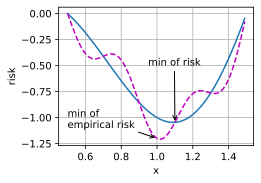

In [3]:
def annotate(text, xy, xytext):  #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

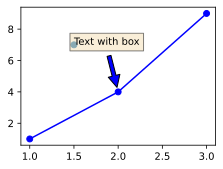

In [4]:
## annotate函数及其参数说明
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([1, 2, 3], [1, 4, 9], 'bo-')
ax.scatter([1.5],[7])

# 注释带有文本框
ax.annotate("Text with box", xy=(2, 4), xytext=(1.5, 7),
            bbox=dict(fc="wheat", ec="black", alpha=0.5),
            arrowprops=dict(facecolor='blue', shrink=0.1))

plt.show()

## 11.1.2 深度学习中的优化挑战

- 在本章中，我们将特别关注**优化算法在最小化目标函数方面的性能**，而不是模型的泛化误差。
- 在 3.1节中，我们区分了优化问题中的**解析解**和**数值解**。
- 在深度学习中，**大多数目标函数都很复杂，没有解析解**。
- 相反，我们必须使用**数值优化算法**，本章中的优化算法都属于此类别。
- 深度学习优化存在许多挑战。其中一些最令人烦恼的是**局部最小值**、**鞍点**和**梯度消失**。

### 11.1.2.1 局部最小值

- 对于任何目标函数$f(x)$，如果在$x$处对应的$f(x)$值小于在$x$附近任何其他点的$f(x)$值，那么$f(x)$可能是**局部最小值**。
- 如果$f(x)$在$x$处的值是整个域上目标函数的最小值，那么$f(x)$是**全局最小值**。
- 例如，给定函数
$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0 \tag{11.1.1}$$

我们可以近似该函数的局部最小值和全局最小值。

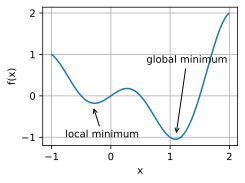

In [5]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

- 深度学习模型的目标函数通常有**许多**局部最优解。
- 当优化问题的数值解接近局部最优值时，**随着目标函数解的梯度接近或变为零**，通过最终迭代获得的数值解可能仅使目标函数**局部**最优，而不是**全局**最优。
- 只有一定程度的噪声可能会使参数超出局部最小值。
- 事实上，这是小批量随机梯度下降的有利特性之一，
  - 在这种情况下，**小批量上梯度的自然变化能够将参数从局部极小值中移出**。

-----------
- **说明：如何理解“小批量上梯度的自然变化能够将参数从局部极小值中移出”？**
  - 首先需要理解梯度下降法的基本原理。在梯度下降法中首先计算损失函数（目标函数）对于参数的梯度，然后以负梯度方向更新参数。当模型到达一个局部最小值时，梯度会接近零，所以参数更新会变得非常小，几乎不再变化。这种情况下，模型或算法可能会被困在这个局部最小值中，无法找到全局最小值。
  - 然而，在小批量随机梯度下降法（mini-batch SGD）中，由于每次仅使用一部分样本计算梯度并更新参数，这在某种程度上引入了一些噪声。这个噪声会导致计算的梯度不会刚好为零，这样参数更新就有可能跳出局部最小值。这是因为噪声可能导致梯度在局部最小值附近发生波动，使得更新的方向不总是指向梯度下降的方向。这种机制提供了一种可能性，使得我们能够跳出局部最小值，并继续搜索更好的解。
  - 例如，考虑一个非凸函数，其中存在多个局部最小值和一个全局最小值。如果采用标准的梯度下降法，在参数初始化到局部最小值附近时，很可能会陷入局部最小值。但是如果使用小批量随机梯度下降法，由于计算梯度时引入的噪声，参数的更新可能会跳过局部最小值，从而有机会找到全局最小值。
  - 请注意，尽管噪声有可能帮助跳出局部最小值，但并不能保证总能找到全局最小值，因为这还取决于许多因素，如学习率、批量大小、参数的初始化等。
  - 从局部极小值中移出的具体方法包括：使用适当的批量大小、使用动量(Momentum)优化器、学习率调度、添加噪声到梯度、使用更先进的优化器等。
-------------

### 11.1.2.2 鞍点
- 除了局部最小值之外，鞍点也是梯度消失的另一个原因。
- **鞍点（saddle point）** 是指函数的所有梯度都消失但既不是全局最小值也不是局部最小值的任何位置。
- 考虑这个函数$f(x) = x^3$。它的一阶和二阶导数在$x=0$时消失。
- 这时优化可能会停止，尽管它不是最小值。

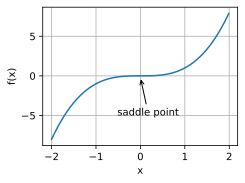

In [6]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

- 如下例所示，较高维度的鞍点甚至更加隐蔽。
- 考虑这个函数$f(x, y) = x^2 - y^2$。它的鞍点为$(0, 0)$。
  - 这是关于$y$的最大值，也是关于$x$的最小值。
  - 此外，它**看起来**像马鞍，这就是这个数学属性的名字由来。


Text(0.5, 0.5, 'y')

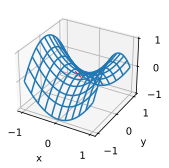

In [7]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101), indexing='xy')
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y')

- 我们假设函数的输入是$k$维向量，其输出是标量，因此其Hessian矩阵（也称黑塞矩阵）将有$k$特征值。**函数的解决方案可以是局部最小值、局部最大值或函数梯度为零的位置处的鞍点：**
  * 当函数在零梯度位置处的Hessian矩阵的特征值全部为正值时，我们有该函数的局部最小值。
  * 当函数在零梯度位置处的Hessian矩阵的特征值全部为负值时，我们有该函数的局部最大值。
  * 当函数在零梯度位置处的Hessian矩阵的特征值为负值和正值时，我们对函数有一个鞍点。
- 对于高维度问题，至少**部分**特征值为负的可能性相当高。
- 这使得鞍点比局部最小值更有可能。我们将在下一节介绍凸性时讨论这种情况的一些例外情况。
- 简而言之，**凸函数是Hessian函数的特征值永远不是负值的函数。** 
- 不幸的是，大多数深度学习问题并不属于这个类别。
- 尽管如此，它还是研究优化算法的一个很好的工具。

-----
- **说明：目标函数Hessian矩阵的作用**
  - Hessian矩阵是一个函数的二阶导数构成的矩阵，有助于理解函数在某个点附近的几何或曲率特性。在多变量函数的优化问题中，通常用Hessian矩阵来确定一个解是局部最小值、最大值，还是鞍点。
  - 特征值在确定函数性质中起了关键的作用。为了更好地理解这一点，首先回顾一下一元函数的情况。对于一元函数，如果函数在某点的一阶导数（即梯度）为0，并且在该点的二阶导数大于0，那么该点就是函数的局部最小值。如果二阶导数小于0，那么该点就是函数的局部最大值。这是因为二阶导数描述了函数曲线的曲率，当二阶导数大于0时，函数在该点附近是向上凸的（"U"型），因此这是一个局部最小值；当二阶导数小于0时，函数在该点附近是向下凸的（"∩"型），因此这是一个局部最大值。
  - 对于多元函数，类似的概念也适用，只是需要考虑函数的所有方向，这就需要用到Hessian矩阵。Hessian矩阵的特征值告诉我们函数在各个方向上的曲率。具体来说，如果Hessian矩阵在某个点的所有特征值都大于0，那么函数在该点附近的所有方向都是向上凸的，因此这个点是函数的局部最小值。如果所有特征值都小于0，那么函数在该点附近的所有方向都是向下凸的，因此这个点是函数的局部最大值。如果Hessian矩阵有正有负的特征值，那么函数在该点附近的某些方向是向上凸的，某些方向是向下凸的，因此这个点是函数的鞍点。
  - 因此，特征值分解在求解优化问题中起着重要的作用，它可以帮助我们确定函数在零梯度位置处的性质，是局部最小值、最大值，还是鞍点。


In [8]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sympy import symbols, lambdify
# 定义变量
x, y = sp.symbols('x y')

# 定义函数
f = x**2 - y**2

# 计算Hessian矩阵
H = sp.hessian(f, (x, y))

print("Hessian矩阵:")
print(H)

# 计算特征值
eigenvalues = H.eigenvals()

print("\n特征值:")
print(eigenvalues)


Hessian矩阵:
Matrix([[2, 0], [0, -2]])

特征值:
{2: 1, -2: 1}


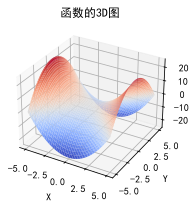

In [9]:


# 设置matplotlib库可以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 定义函数
x, y = symbols('x y')
f = x**2 - y**2

# Lambdify函数
f_lambdified = lambdify((x, y), f, "numpy")

# 创建x, y值的网格
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5, 100)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)

# 计算函数值
f_vals = f_lambdified(x_vals, y_vals)

# 创建图形窗口并设置大小
fig = plt.figure(figsize=(8, 3))  # 设置图形宽 10 英寸，高 6 英寸

# 添加 3D 子图
ax1 = fig.add_subplot(111, projection='3d')

# 绘制 3D 曲面
ax1.plot_surface(x_vals, y_vals, f_vals, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# 设置坐标轴标签和标题
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('函数的3D图')

# 显示图形
plt.show()

- **代码说明：**
  - 上述代码为函数 $f(x, y) = x^2 - y^2$ 创建了可视化图形。
  - 在左侧的3D图中可以看到函数形状类似于一个鞍，这与对该函数的期望相符。
  - 因为这是一个鞍点函数，其Hessian矩阵在每个点都有一个正的特征值和一个负的特征值。
  - 对于凸函数，Hessian矩阵的所有特征值都是正的，而对于凹函数，所有特征值都是负的。
  - 对于鞍点函数，Hessian矩阵有正有负的特征值。
    - 多元目标函数$f(x,y) = x^2 - y^2$的Hessian矩阵特征值为2和-2，因此其是鞍点函数。

----------

### 11.1.2.3梯度消失

- 可能遇到的最隐蔽的问题是梯度消失。
- 在4.1.2节中常用的激活函数及其衍生函数。
  - 例如，假设想最小化函数$f(x) = \tanh(x)$，然后恰好从$x = 4$开始。
  - 正如所看到的那样，$f$的梯度接近零。
  - 更具体地说，$f'(x) = 1 - \tanh^2(x)$，因此是$f'(4) = 0.0013$。
  - 因此，在我们取得进展之前，优化将会停滞很长一段时间。
- 事实证明，这是在引入ReLU激活函数之前训练深度学习模型相当棘手的原因之一。

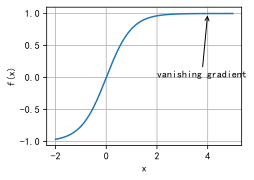

In [10]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

- 没有必要找到最佳解决方案。
- **局部最优解或其近似解仍然非常有用**。

## 小结

* 最小化训练误差并*不能*保证我们找到最佳的参数集来最小化泛化误差。
* 优化问题可能有许多局部最小值。
* 问题可能有更多的鞍点，因为通常问题不是凸的。
* 梯度消失可能会导致优化停滞，重参数化通常会有所帮助。对参数进行良好的初始化也可能是有益的。